In this experiment, we demonstrate that the effect of training a CNN with one layer, initialized by PCA coefficients, on pairs of CQT images, whether or not they are similar or non-similar. In the experiment, we used the PCA coefficients trained on original HashPrint approach's dataset. The annotation dataset is used for training to distinguish similar pairs and non-similar pairs. 

In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[hashnet-kapre]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = True      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import os
import importlib
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

import songdb
data_dict = songdb.data_dict

from preprocess import *
from model import build_model

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='[{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-04-12 00:37:54,077 - root - DEBUG - Keras backend is tensorflow.
2018-04-12 00:37:54,081 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 20, 121)`.

In [8]:
audio_len = 22050
preproc_model = normalization_model(audio_len)

In [9]:
logger.debug("Load Paired-annotation data")
# data = annotations.get_ref_query_pairs("taylorswift", beat_width=5900)
data = data_dict()["taylorswift"]
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))

songPairs = []
totalPairs = 0 
for ref, query in data:
    # Preprocess ref, query
    assert ref.shape[1] == audio_len, ref.shape
    assert query.shape[1] == audio_len, query.shape

    ref = run_preprocessing(preproc_model, ref)
    query = run_preprocessing(preproc_model, query)
    
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        ref_array = np.asfarray(ref[i], dtype='float32')
        refQ = preprocess(librosa.cqt(ref_array, sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        
        query_array = np.asfarray(query[i], dtype='float32')
        queryQ = preprocess(librosa.cqt(query_array, sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair[:,:,28:48,:]) 
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-04-12 00:41:26,239 - root - DEBUG - Load Paired-annotation data
2018-04-12 00:41:26,244 - root - DEBUG - 	 data.type = <class 'generator'>
2018-04-12 00:41:26,246 - root - DEBUG - 	 data = <generator object get_ref_query_pairs at 0x000002A9BC6CFF68>
2018-04-12 00:42:18,620 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 20, 121)
2018-04-12 00:42:18,623 - root - DEBUG - Number of samples for the current song: 272
2018-04-12 00:43:13,027 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 20, 121)
2018-04-12 00:43:13,033 - root - DEBUG - Number of samples for the current song: 264
2018-04-12 00:43:34,294 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 20, 121)
2018-04-12 00:43:34,297 - root - DEBUG - Number of samples for the current song: 100
2018-04-12 00:43:54,475 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 20, 121)
2018-04-12 00:43:54,477 - root - DEBUG - Number of samples for the current song: 100
2

In [10]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-04-12 00:58:24,748 - root - DEBUG - Finish loading paired-annotation data
2018-04-12 00:58:24,753 - root - DEBUG - => There are 14 songs for training [63.52 percent]
2018-04-12 00:58:24,755 - root - DEBUG - => There are 6 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [11]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [12]:
X1, X2, S, W, groundTruth = generate_training_data(data_train, nNonSimilar=4000)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val, nNonSimilar=2000)

2018-04-12 00:58:40,609 - root - DEBUG - X1 shape: (7237, 1, 20, 121)
2018-04-12 00:58:40,612 - root - DEBUG - X2 shape: (7237, 1, 20, 121)
2018-04-12 00:58:40,614 - root - DEBUG - S shape: (7237, 1)
2018-04-12 00:58:40,616 - root - DEBUG - W shape: (7237, 1)
2018-04-12 00:58:40,656 - root - DEBUG - There are 3237 out of 7237 pairs that are similar [44.73 percent]
2018-04-12 00:58:41,098 - root - DEBUG - X1 shape: (3859, 1, 20, 121)
2018-04-12 00:58:41,100 - root - DEBUG - X2 shape: (3859, 1, 20, 121)
2018-04-12 00:58:41,102 - root - DEBUG - S shape: (3859, 1)
2018-04-12 00:58:41,104 - root - DEBUG - W shape: (3859, 1)
2018-04-12 00:58:41,106 - root - DEBUG - There are 1859 out of 3859 pairs that are similar [48.17 percent]


In [13]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [14]:
width = 20
height = 121
n_channel = 1

In [15]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [16]:
model_path = 'model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-04-12 00:58:48,739 - root - DEBUG - Load model from model.mat


In [17]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, (width, height), delta=delta, compute_delta=False)

### Remove this block of code if you want to have original hashprint model.

In [18]:
PCA_layer = base_model.layers[0]
PCA_layer.trainable = False
base_model.pop()
base_model.add(BatchNormalization(input_shape=(n_channel, width, height)))
base_model.add(Convolution2D(64, (20,1)))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(64, (1,3), padding='same'))
base_model.add(Dropout(0.5))
base_model.add(Convolution2D(64, (1,3), padding='same'))

In [19]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [20]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [21]:
beta         = 1            # Initial beta value
numberOfBits = 64
alpha        = 0.01         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-04-12 00:59:01,544 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = 64, alpha = 0.01


In [22]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [23]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [24]:
hash_layer = Dense(numberOfBits, activation='tanh')
encoded_a = hash_layer(flatten_a)
encoded_b = hash_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [25]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-04-12 00:59:07,872 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [26]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [27]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-2")
adam = Adam(lr=1e-2, decay=1e-2)
model.compile(optimizer=adam, loss=zero_loss)

2018-04-12 00:59:08,959 - root - DEBUG - Use Adam optimizer with lr = 1e-2


__Visualize model architecture__

In [28]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [29]:
representation_model = Model(image_a, encoded_a)

In [30]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    bins = np.linspace(0, max(max(hist_sim), max(hist_non_sim)), 100)
    plt.ylim((0, 400))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

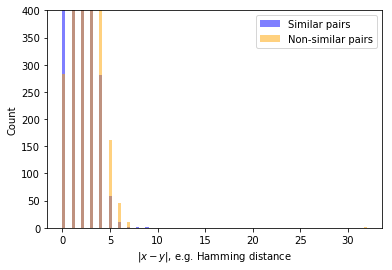

In [31]:
visualize(X1, X2, groundTruth, representation_model)

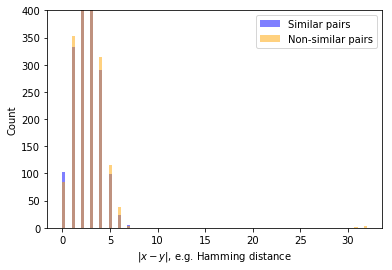

In [32]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [33]:
## Training Data

In [34]:
pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    if similarity:
        outputs_sim.append((score, X1[idx], X2[idx]))
    else:
        outputs_nonsim.append((score, X1[idx], X2[idx]))

In [35]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from training data that are most similar')

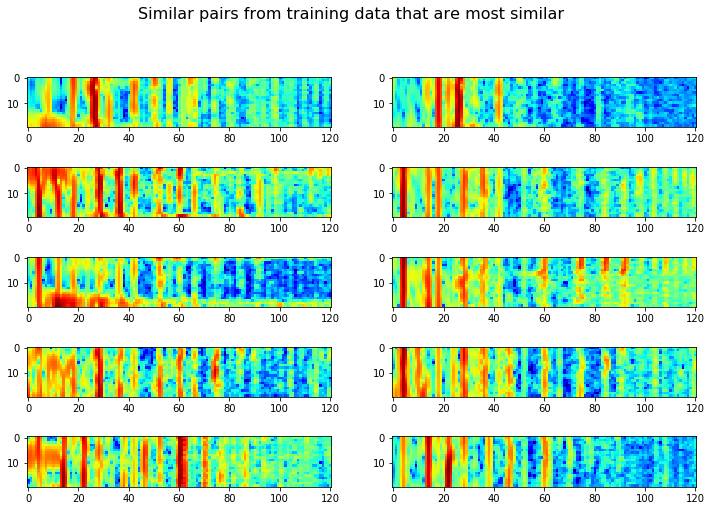

In [36]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Similar pairs from training data that are least similar')

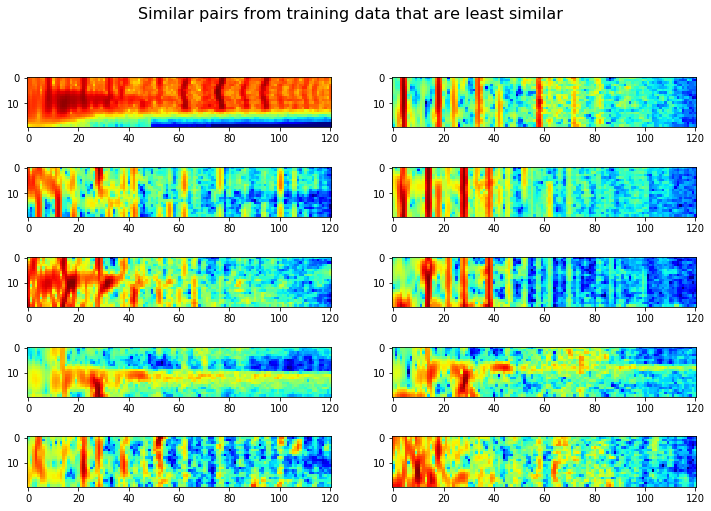

In [37]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from training data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are most similar')

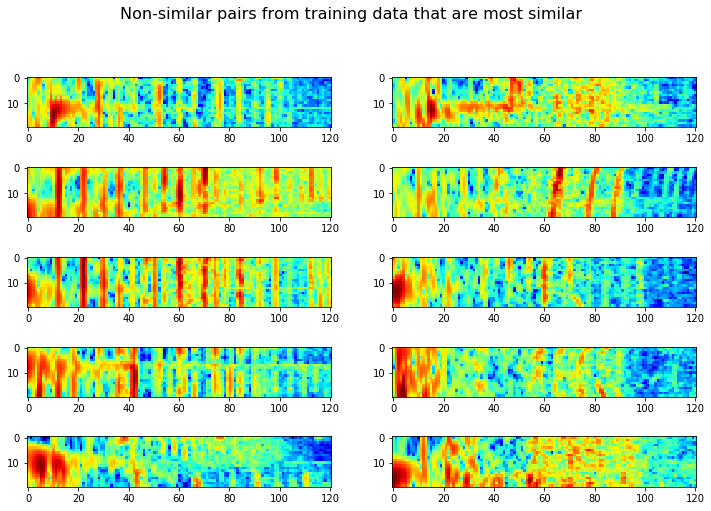

In [38]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from training data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from training data that are least similar')

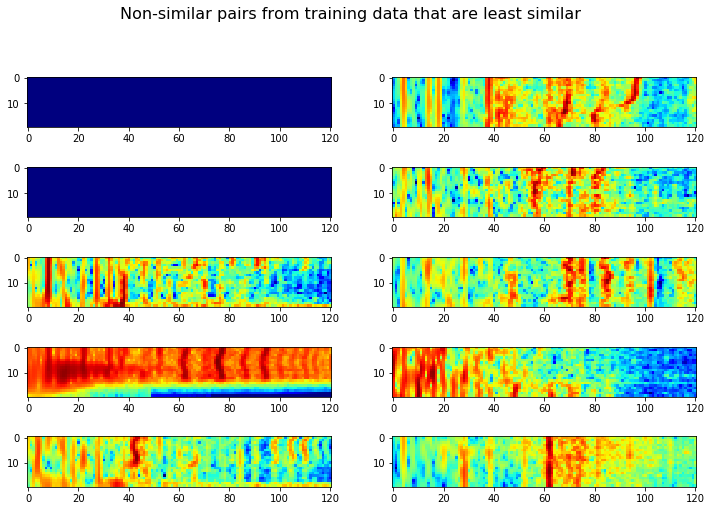

In [39]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Non-similar pairs from training data that are least similar", fontsize=16)

In [40]:
## Validation Data

In [41]:
pred_X1 = (representation_model.predict(X1_val) > 0)
pred_X2 = (representation_model.predict(X2_val) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth_val[idx][0] == groundTruth_val[idx][1])
    if similarity:
        outputs_sim.append((score, X1_val[idx], X2_val[idx]))
    else:
        outputs_nonsim.append((score, X1_val[idx], X2_val[idx]))

In [42]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

Text(0.5,0.98,'Similar pairs from validation data that are most similar')

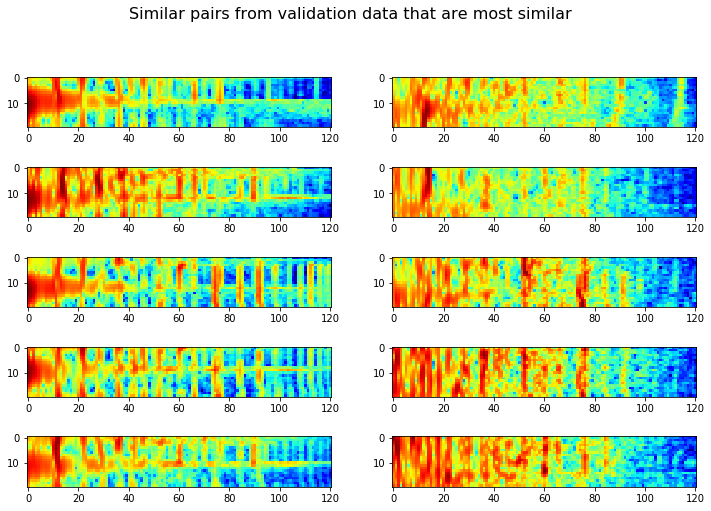

In [43]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from validation data that are most similar", fontsize=16)

Text(0.5,0.98,'Similar pairs from validation data that are least similar')

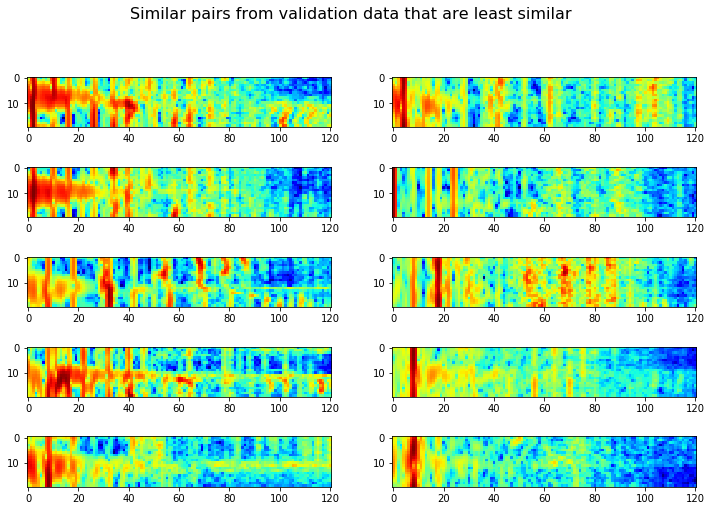

In [44]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from validation data that are least similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are most similar')

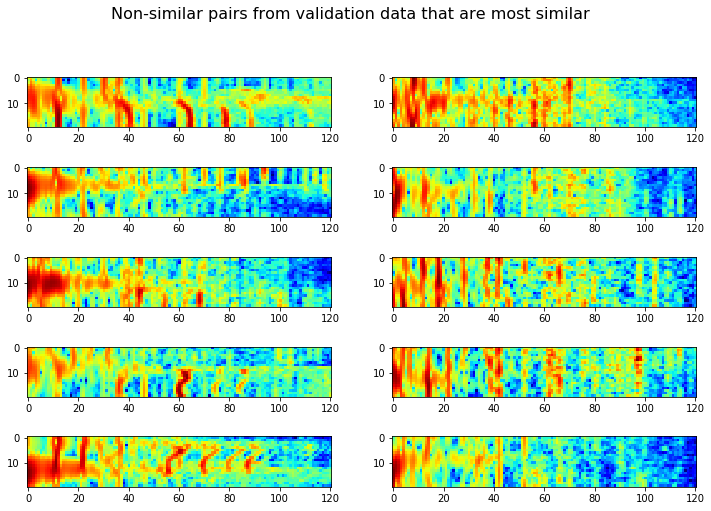

In [45]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are most similar", fontsize=16)

Text(0.5,0.98,'Non-similar pairs from validation data that are least similar')

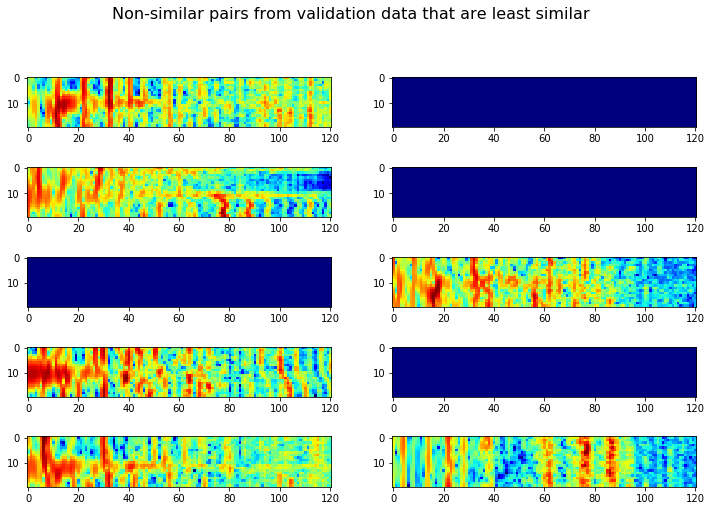

In [46]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are least similar", fontsize=16)    

## Train a model

In [47]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-04-12 01:00:06,387 - root - DEBUG - Ready to train the model
2018-04-12 01:00:06,397 - root - DEBUG - X1 shape: (7237, 1, 20, 121)
2018-04-12 01:00:06,404 - root - DEBUG - X2 shape: (7237, 1, 20, 121)
2018-04-12 01:00:06,426 - root - DEBUG - S shape: (7237, 1)
2018-04-12 01:00:06,485 - root - DEBUG - W shape: (7237, 1)


In [48]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta = 1
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 100
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-04-12 01:00:06,512 - root - DEBUG - [Training] number_of_iterations = 100
2018-04-12 01:00:06,518 - root - DEBUG - [Training] beta_factor = 1.5
2018-04-12 01:00:06,523 - root - DEBUG - [Training] number_of_epochs = 100


In [49]:
train_losses = []
test_losses = []
m = 0

2018-04-12 01:00:06,848 - root - DEBUG - Iteration 0 (current beta = 1)
Train on 7237 samples, validate on 3859 samples
Epoch 1/100
7237/7237 [==============================] - 21s 3ms/step - loss: 42.2481 - val_loss: 44.1924
Epoch 2/100
7237/7237 [==============================] - 23s 3ms/step - loss: 42.5504 - val_loss: 43.7121
Epoch 3/100
7237/7237 [==============================] - 20s 3ms/step - loss: 42.6460 - val_loss: 42.7973
Epoch 4/100
7237/7237 [==============================] - 18s 2ms/step - loss: 42.6703 - val_loss: 44.0626
Epoch 5/100
7237/7237 [==============================] - 18s 2ms/step - loss: 42.7489 - val_loss: 43.1726
Epoch 6/100
7237/7237 [==============================] - 17s 2ms/step - loss: 42.7321 - val_loss: 44.3136
Epoch 7/100
7237/7237 [==============================] - 18s 2ms/step - loss: 42.7324 - val_loss: 43.4122
Epoch 8/100
7237/7237 [==============================] - 19s 3ms/step - loss: 42.7345 - val_loss: 43.3747
Epoch 9/100
7237/7237 [=========

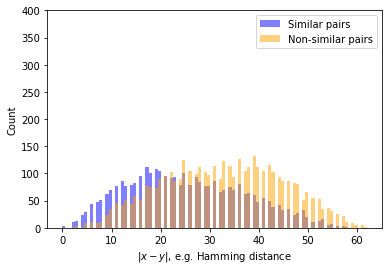

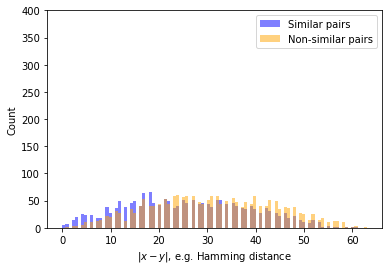

3859/3859 [==============================] - 3s 729us/step
2018-04-12 01:30:58,819 - root - DEBUG - [Iteration = 1] Training Loss = 42.509259635742914, Testing Loss = 43.246944971670295
2018-04-12 01:30:58,848 - root - DEBUG - Iteration 1 (current beta = 1.5)
Train on 7237 samples, validate on 3859 samples
Epoch 1/100
7237/7237 [==============================] - 17s 2ms/step - loss: 42.1546 - val_loss: 44.0983
Epoch 2/100
7237/7237 [==============================] - 17s 2ms/step - loss: 42.1342 - val_loss: 43.3042
Epoch 3/100
7237/7237 [==============================] - 18s 2ms/step - loss: 42.1644 - val_loss: 43.3100
Epoch 4/100
7237/7237 [==============================] - 16s 2ms/step - loss: 42.1452 - val_loss: 43.2392
Epoch 5/100
7237/7237 [==============================] - 15s 2ms/step - loss: 42.1528 - val_loss: 43.2170
Epoch 6/100
7237/7237 [==============================] - 16s 2ms/step - loss: 42.2385 - val_loss: 43.2266
Epoch 7/100
7237/7237 [==============================] -

In [ ]:
for i in range(number_of_iterations):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    m += 1

    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], 
              validation_data=({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val]),
              verbose=verbose, 
              epochs=number_of_epochs)
    beta *= beta_factor

    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)

    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

In [ ]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

## Save Model

In [ ]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(m)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [ ]:
representation_model = Model(image_a, encoded_a)

In [ ]:
# Get sample output
test_model = Model(image_a, flatten_a)
pred_X1 = test_model.predict(X1)
pred_X2 = test_model.predict(X2)
plt.imshow(pred_X1[:200])
plt.show()

In [ ]:
# Visualize the representation before threshold.
test_model = Model(image_a, encoded_a)
pred_X1 = test_model.predict(X1)
pred_X2 = test_model.predict(X2)
plt.figure(figsize=(12,8))
plt.imshow(pred_X1[400:700])
plt.show()

In [ ]:
# Plot bit importance of X1
plt.plot(np.sum(pred_X1 > 0, axis=0) / len(pred_X1))

In [ ]:
# Plot bit importance of X2
plt.plot(np.sum(pred_X2 > 0, axis=0) / len(pred_X2))

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

In [ ]:
# Visualize the layer before Dense
representation_model = Model(image_a, flatten_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [ ]:
# Visualize the dense layer
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [ ]:
## Training Data

In [ ]:
pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    if similarity:
        outputs_sim.append((score, X1[idx], X2[idx]))
    else:
        outputs_nonsim.append((score, X1[idx], X2[idx]))

In [ ]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

In [ ]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from training data that are most similar", fontsize=16)

In [ ]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from training data that are least similar", fontsize=16)

In [ ]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from training data that are most similar", fontsize=16)

In [ ]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Non-similar pairs from training data that are least similar", fontsize=16)

In [ ]:
## Validation Data

In [ ]:
pred_X1 = (representation_model.predict(X1_val) > 0)
pred_X2 = (representation_model.predict(X2_val) > 0)
outputs_sim    = []
outputs_nonsim = []
for idx in range(len(pred_X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth_val[idx][0] == groundTruth_val[idx][1])
    if similarity:
        outputs_sim.append((score, X1_val[idx], X2_val[idx]))
    else:
        outputs_nonsim.append((score, X1_val[idx], X2_val[idx]))

In [ ]:
outputs_sim = sorted(outputs_sim, key=lambda x: x[0]);
outputs_nonsim = sorted(outputs_nonsim, key=lambda x: x[0]);

In [ ]:
# Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Similar pairs from validation data that are most similar", fontsize=16)

In [ ]:
outputs_sim[0]

In [ ]:
# furthest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_sim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_sim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')
    
plt.suptitle("Similar pairs from validation data that are least similar", fontsize=16)

In [ ]:
# Non-Similar pairs
# closest
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[i][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[i][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are most similar", fontsize=16)

In [ ]:
# furthest    
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(5,2,2*i+1)
    plt.imshow(outputs_nonsim[-i-1][1][0,:,:].reshape(20,-1), cmap='jet')
    plt.subplot(5,2,2*i+2)
    plt.imshow(outputs_nonsim[-i-1][2][0,:,:].reshape(20,-1), cmap='jet')

plt.suptitle("Non-similar pairs from validation data that are least similar", fontsize=16)    

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(representation_model.predict(X1_val).reshape(64,-1))

## Appendix: Architecture Details

In [ ]:
base_model.summary()

# Evaluate for MRR

This evaluation is not similar to the original hashprint approach, as it truncates the query to be the same size as the size of `base_model.input_shape`.

In [ ]:
import os
import h5py
from preprocess import get_allpaths
from search import calculateMRR

In [ ]:
DATA_OUTPUT_DIR = "/data/mjenrungrot/live-song-output/" # Location to store *.npy files
AUDIO_DIR = "/home/mirlab/Data/SoftLinks/"              # Location of audio files input

In [ ]:
ref_files = get_allpaths('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'))

In [ ]:
f = open(os.path.join(DATA_OUTPUT_DIR, 'taylorswift_cqtList.txt'), 'w')
for ref_file in ref_files:
    logger.debug("Process {:}".format(ref_file))
    audio_file = os.path.join(AUDIO_DIR, ref_file + '.wav')
    y, sr = librosa.load(audio_file)
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    
    # Preprocess CQT to logQ
    ds = 3
    absQ = np.absolute(Q)
    smoothQ = np.zeros((absQ.shape[0], absQ.shape[1]//ds))
    for row in range(absQ.shape[0]):
        smoothQ[row] = np.convolve(absQ[row], [1/ds]*ds, 'valid')[0:absQ.shape[1]-ds+1:ds]
    logQ = np.log(1+1000000*smoothQ)
    
    output_file = os.path.join(DATA_OUTPUT_DIR, ref_file + '.npy')
    np.save(output_file, logQ)
    f.write(ref_file + '.npy\n')
f.close()

In [ ]:
db_path = os.path.join(DATA_OUTPUT_DIR, "taylorswift_db.hdf5")
db = h5py.File(db_path, mode='w')
f = open(os.path.join(DATA_OUTPUT_DIR, 'taylorswift_cqtList.txt'), 'r')

In [ ]:
db.close()
f.close()

In [ ]:
def pitch_shift_CQT(M, shiftBins):
    """
        pitchshift equivalent of Prof Tsai's code in matlab
        M: a 2-D CQT matrix
        shiftBins: An integer that indicates the pitch to shift to
        return: a pitchshifted matrix
    """
    shifted = np.roll(M, shiftBins, axis=0)
    if shiftBins > 0:
        shifted[:shiftBins, :] = 0.
    else:
        shifted[shiftBins:, :] = 0.
    return shifted

In [ ]:
for line in f:
    logger.debug('==> Generating database for %s' % os.path.basename(line)[:-1])
    full_path = os.path.join(DATA_OUTPUT_DIR, line[:-1])
    Q = np.load(full_path).T
    
    # Reshape
    width, height = Q.shape
    Q = Q[:(width - width%20)].reshape(-1, 1, 20, 121)
    
    pitch_shift_Qs = np.empty((9, ) + Q.shape)
    pitch_shift_Qs[0, :, :] = Q
    for i in range(1, 5):
        pitch_shift_Qs[i, :, :] = pitch_shift_CQT(Q.T, i).T
    for i in range(1, 5):
        pitch_shift_Qs[i + 4, :, :] = pitch_shift_CQT(Q.T, -i).T
    
    fpseqs = np.array([base_model.predict(pitch_shift_Qs[i]) for i in range(pitch_shift_Qs.shape[0])])

    key = os.path.basename(line)[:-1]
    fpseqs = fpseqs.reshape(9,-1,64)
    db.create_dataset(key, fpseqs.shape, np.bool)
    db[key][...] = np.where(fpseqs > 0, True, False)
f.close()
db.close()

In [ ]:
db_path = os.path.join(DATA_OUTPUT_DIR, 'taylorswift_db.hdf5')
db = h5py.File(db_path, mode='r')

In [ ]:
query_paths = get_allpaths('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'), file_type='query')

In [ ]:
def get_query_shape():
    '''
        returns the shape of query file in (width, height)
    '''
    assert len(query_paths) > 0
    cur_file = query_paths[0]
    y, sr = librosa.load(AUDIO_DIR + cur_file + '.wav')
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    logQ = preprocess(Q, 3)
    return logQ.T.shape

In [ ]:
query_shape = get_query_shape()
queries = np.empty((len(query_paths), ) + query_shape)

In [ ]:
for i in range(len(query_paths)):
    cur_file = query_paths[i]
    print('==> Computing CQT of %s'%cur_file)
    y, sr = librosa.load(AUDIO_DIR + cur_file + '.wav')
    Q = librosa.cqt(y, sr=sr, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)
    logQ = preprocess(Q, 3)
    queries[i, :, :] = logQ.T

In [ ]:
q = []
for query in queries:
    width, height = query.shape
    query = query[:(width - width%20), :].reshape(-1, 1, 20, 121)
    output = np.where(representation_model.predict(query) > 0, True, False)
    q.append(output)

In [ ]:
def get_querytoref(artist, listdir):
    '''
        artist: a string representing the artist
        listdir: a string representing the directory of the .list file
        returns an array of integer, where each entry corresponds to the
            reference index
    '''

    ref_idxs = []
    f = open(listdir+artist+'_querytoref.list', 'r')
    for line in f:
        ref_idx = (line.split(' '))[1]
        ref_idxs.append(int(ref_idx))
    f.close()
    return ref_idxs

In [ ]:
refs = list(db.values())
ground_truths = get_querytoref('taylorswift', os.path.join(AUDIO_DIR, 'Lists/'))

In [ ]:
mrr = calculateMRR(q, refs, ground_truths)

In [ ]:
mrr

In [ ]:
q[0].shape